In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
from torchsummary import summary
import scipy
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
import os
import tqdm

In [2]:
class Unet(torch.nn.Module):
    
    
    def downBlock(self, in_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(out_channels),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(out_channels))
        return block
    def upBlock(self,in_channels, mid_channels,out_channels, kernel_size):
        block = torch.nn.Sequential(torch.nn.Conv2d(in_channels, mid_channels, kernel_size),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(mid_channels),
                                    torch.nn.Conv2d(mid_channels, mid_channels, kernel_size),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(mid_channels),
                                    torch.nn.ConvTranspose2d(mid_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1))
        return block
    
    def finalBlock(self,in_channels, mid_channels, out_channels, kernel_size):
        block = torch.nn.Sequential(torch.nn.Conv2d(in_channels, mid_channels, kernel_size),
                                   torch.nn.ReLU(),
                                   torch.nn.BatchNorm2d(mid_channels),
                                   torch.nn.Conv2d(mid_channels, mid_channels, kernel_size), 
                                   torch.nn.ReLU(),
                                   torch.nn.BatchNorm2d(mid_channels),
                                   torch.nn.Conv2d(mid_channels, out_channels, kernel_size, padding = 1),
                                   torch.nn.ReLU(),
                                   torch.nn.BatchNorm2d(out_channels))
        return block
    
    
    
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()
        
        #Encoder
        self.encode1 = self.downBlock(in_channels, out_channels = 64, kernel_size = 3)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.encode2 = self.downBlock(64, 128, 3)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)
        self.encode3 = self.downBlock(128, 256, 3)        
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size = 2)
        
        #bottleneck layer
        
        self.bottleneck = torch.nn.Sequential(torch.nn.Conv2d(256,512,3),
                                             torch.nn.ReLU(),
                                             torch.nn.BatchNorm2d(512),
                                             torch.nn.Conv2d(512,512,3),
                                             torch.nn.ReLU(),
                                             torch.nn.BatchNorm2d(512),
                                             torch.nn.ConvTranspose2d(512,256, kernel_size = 3, stride = 2, padding = 1, output_padding = 1 ))
        self.decode3 = self.upBlock(512,256,128,3)
        self.decode2 = self.upBlock(256, 128, 64, 3)
        self.finalLayer = self.finalBlock(128, 64, out_channels, 3)
        
    def copy_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
        
    def forward(self, x):
        
        #encoder
        encodeBlock1 = self.encode1(x)
        encodePool1 = self.maxpool1(encodeBlock1)
        encodeBlock2 = self.encode2(encodePool1)
        encodePool2 = self.maxpool2(encodeBlock2)
        encodeBlock3 = self.encode3(encodePool2)
        encodePool3 = self.maxpool3(encodeBlock3)
        
        #bottleneck
        
        bottleneck1 = self.bottleneck(encodePool3)
        
        #decoder
        
        cat3 = self.copy_concat(bottleneck1, encodeBlock3, True)
        decodeBlock3 = self.decode3(cat3)
        cat2 = self.copy_concat(decodeBlock3, encodeBlock2, True)
        decodeBlock2 = self.decode2(cat2)
        cat1 = self.copy_concat(decodeBlock2, encodeBlock1, True)
        finalBlock = self.finalLayer(cat1)
        return finalBlock

        
unet = Unet(in_channels=1,out_channels=2)

In [85]:
path = 'C:/Users/Anand/Desktop/project/ImageSegmentation/chiu-2015/2015_BOE_Chiu'

In [86]:
dataPath = [os.path.join(path, 'Subject_0{}.mat'.format(i)) for i in range(1,10)] + [os.path.join(path, 'Subject_10.mat')]

In [87]:
WIDTH = 284
HEIGHT = 284
WIDTHOUT = 196
HEIGHTOUT = 196
indices = [i for i in range(5,55, 5)]

In [88]:
mat = loadmat(dataPath[0])
img_tensor = mat['images']
manual_fluid_tensor = mat['manualFluid1']

In [89]:
manual_fluid_tensor[35]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [91]:
img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor, (2, 0, 1))


In [92]:
manual_fluid_array

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [93]:
temp = np.resize(img_array, (61, 250,250))

In [94]:
out = np.array(manual_fluid_array, dtype = np.float)
out = out > 0.5

C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [95]:
out.shape

(61, 496, 768)

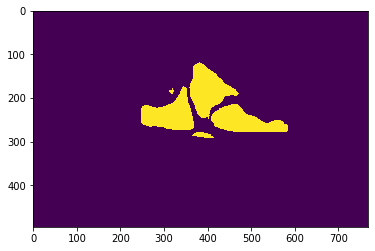

In [96]:
plt.imshow(out[30])

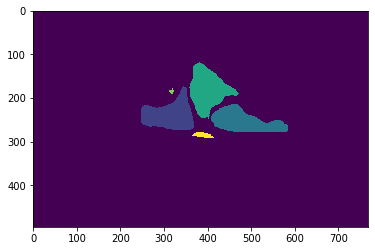

In [22]:
plt.imshow(manual_fluid_array[30])

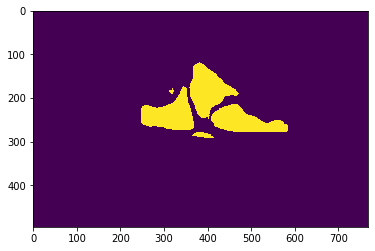

In [27]:
plt.imshow(thresh(manual_fluid_array[30]))

In [75]:

def createDataSet(paths):
    x = list()
    y = list()
    
    for path in tqdm.tqdm(paths):
        mat = loadmat(path)
        images = mat['images']
        fluidTensor = mat['manualFluid1']
        print(fluidTensor)
        images = np.transpose(images, (2,0,1))
        images = np.resize(images, (images.shape[0], WIDTH, HEIGHT))
        fluidArray = np.transpose(fluidTensor, (2,0,1))
        fluidArray = np.array(fluidArray, dtype = np.float)
        fliudArray = fluidArray > 0.5
        fludiArray = np.resize(fluidArray, (fluidArray.shape[0], WIDTHOUT, HEIGHTOUT))
        
        for index in indices:
            x = x + [np.expand_dims(images[index], 0)]
            y = y + [np.expand_dims(fludiArray[index], 0)]
    return np.array(x), np.array(y)

trainX, trainY = createDataSet(dataPath[:9])
valX, valY = createDataSet(dataPath[9:])

  0%|          | 0/9 [00:00<?, ?it/s]

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
 11%|█         | 1/9 [00:01<00:12,  1.57s/it]

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

 22%|██▏       | 2/9 [00:03<00:11,  1.60s/it]

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

 33%|███▎      | 3/9 [00:04<00:09,  1.62s/it]

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

 44%|████▍     | 4/9 [00:06<00:08,  1.63s/it]

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

 56%|█████▌    | 5/9 [00:08<00:06,  1.65s/it]


KeyboardInterrupt: 

In [69]:
trainX.shape, trainY.shape, valX.shape, valY.shape

((90, 1, 284, 284), (90, 1, 196, 196), (10, 1, 284, 284), (10, 1, 196, 196))

In [73]:
trainY[0]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [12]:
BATCHSIZE = 18
EPOCHS = 100
THRESHOLD = 0.5


In [13]:
def train(model, optimizer, criterion, inputs, labels):
    optimizer.zero_grad()
    # Forward, optimize, backward
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    outputs = model(inputs)
    outputs = outputs.permute(0, 2, 3, 1) #check this one, if possible remove it
    
    labels = labels.resize(BATCHSIZE * WIDTHOUT * HEIGHTOUT, 2) #change this one
    outputs = outputs.resize(BATCHSIZE * WIDTHOUT * HEIGHTOUT, 2)
    loss = criterion(outputs, labels)
    optimizer.step()
    return loss

In [14]:
learningRate = 0.02
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = learningRate, momentum=0.99)


In [15]:
def validationLoss(valX, valY):
    valX = torch.from_numpy(valX).float()
    valY = torch.from_numpy(valY).float()
    if torch.cuda.is_available():
        valX = valX.cuda()
        valY = valY.cuda()
    outputs = unet(valX, valY)
    outputs = outputs.resize(BATCHSIZE * WIDTHOUT * HEIGHTOUT, 2)
    labels = valY.resize(BATCHSIZE * WIDTHOUT * HEIGHTOUT, 2) #change this one
    loss = F.cross_entropy(outputs, labels)
    return loss.data
    

In [16]:
BATCHES = trainX.shape[0] // BATCHSIZE
unet = unet.cuda()

In [17]:
for batch in range(BATCHES):
    totalLoss = 0
    for i in range(EPOCHS):
        batchX = torch.from_numpy(trainX[i * BATCHSIZE : (i+1) * BATCHSIZE]).float()
        batchY = torch.from_numpy(trainY[i * BATCHSIZE : (i+1) * BATCHSIZE]).float()
        batchLoss = train(unet, optimizer, criterion, batchX, batchY)
        totalLoss += batchLoss
        
        if int(i / 10) == 0:
            valLoss = validationLoss(valX, valY)
            print('Loss at epoch {} is {}'.format(i, valLoss))

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 6.00 GiB total capacity; 4.54 GiB already allocated; 9.14 MiB free; 26.48 MiB cached)